# Convex optimization on vertical slicing
----------
This repository provide useful tools for human segmentation in Python 3.5. It provides projection, keypoints and segmentation and functions to greatly reduce computation.
## Requirements:
- numpy
- matplotlib
- skimage
- sklearn

In [1]:
from convex import *
from utils import *
import matplotlib.pyplot as plt
import os

In [2]:
fpath = './a3d/a3d/0d925b71485ba1f293ef8abb53fcd141.a3d'
data = read_data(fpath) # read the a3d file

read ./a3d/a3d/0d925b71485ba1f293ef8abb53fcd141.a3d costs 33.86859583854675s


## Preprocessing

In [3]:
ratio = 4
# compress the dimension by 4 for faster speed, thus the new dimension is 128x128x165
data = compress_data(data, ratio) 
# apply ostu threshold on each layer to get binary data
out,_ = ostu3d(data) 

# scaning the data with a cube of size(sz) 4 and moving with the stride(sd) of 4. if point density inside the box is lower than 0.2,
# remove these points/noise. Otherwise, sample 2 points from them.
# the trick greatly relieve the unbalanced sample density and reduce computation
sampled, flags = sampling3d(out, sz=4, sd=4, threshold=0.2 ,nsampling=2)

ostu takes 0.23267126083374023s
sampling takes 0.8494977951049805 sec


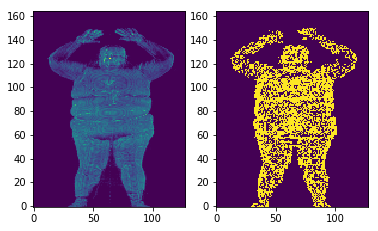

In [4]:
fig, axes = plt.subplots(1,2)
axes[0].imshow(np.flipud(pc2img(data, axis=1)), origin='lower')
axes[1].imshow(np.flipud(pc2img(sampled, threshold=0, axis=1)), origin='lower')
plt.show()

correct the hypo.
frame generated in 11.388538360595703 s


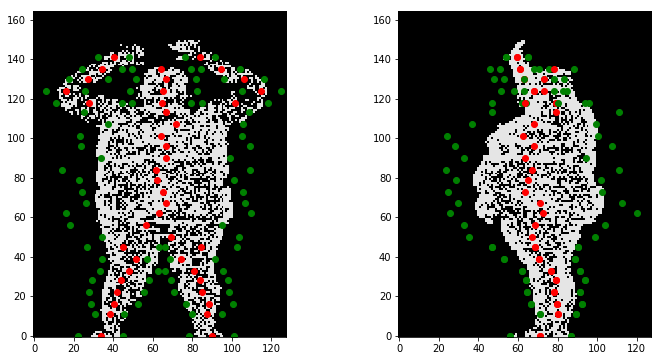

The hip      is at 50
The waist    is at 75.0
The neck     is at 118
The shoulder is at 118
Top of head  is at 141


In [5]:
layers = np.linspace(0, sampled.shape[2]-1, 30, dtype=np.int16)
x, y, z, b, d, flags = frame_gen(sampled, layers, ratio=ratio, penalty=1, min_thresh=20, verbose=False)
flags = find_neck(out, flags)
print('The hip      is at {}'.format(flags['hip']))
print('The waist    is at {}'.format(flags['waist']))
print('The neck     is at {}'.format(flags['neck']))
print('The shoulder is at {}'.format(flags['neck']))
print('Top of head  is at {}'.format(flags['top']))
# red points are centroids and green points are boundary of the cluster

In [6]:
# to save keypoints
if not os.path.exists('keypoints'):
    os.mkdir('keypoints')
save_pts('./keypoints/0d925b71485ba1f293ef8abb53fcd141.txt', x, y, z, ratio)
# If you just need the keypoints, run
# get_frames(./data/a3d_path, ./output_path, n_layers=40)

In [ ]:
frame_parser()

## Under the hood
--------------------
The keypoints are generated through scaning the vertical slice of the human point cloud. We use multiple ellipses
to fit the points and find the best fit in each vertical slices.

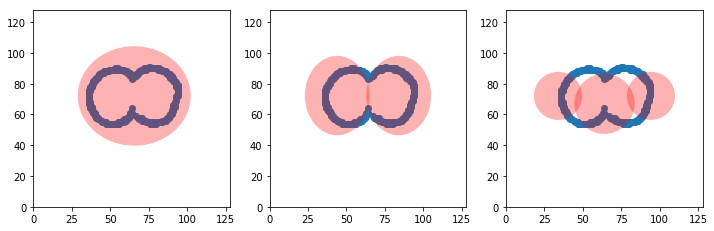

probability for each hypothesis:  [ 0.33409511  0.33472566  0.33117923]


In [7]:
indx = 50
pts = get_points(out[:,:,indx], thresh=0)
geom, probs = cluster_gen(pts, ratio=4, if_plot=True, radius_penalty=1)
print('probability for each hypothesis: ', probs)

The cluster_gen method provide three hypothesis and minimize the relative distance 
between a point to its closest centroid in each slice. however this can be wrong in
some cases.

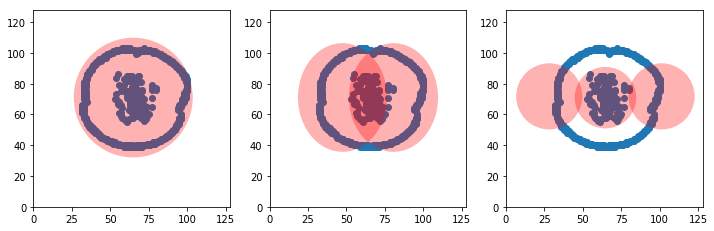

probability for each hypothesis:  [ 0.3389522   0.33376836  0.32727944]


In [8]:
indx = 65
pts = get_points(out[:,:,indx], thresh=0)
geom, probs = cluster_gen(pts, ratio=4, if_plot=True, radius_penalty=1)
print('probability for each hypothesis: ', probs)

All data points in this example obviously belong to a single cluster. So the prediction is wrong. 
Therefore we need to correct it based on our knowledge of geometry and human anatomy. See the detail
in function **find_neck** and **correct_hypo** from convex.py

## Some results

In [ ]:
from glob import glob
flist = glob('./a3d/a3d/*.a3d')
for i, fpath in enumerate(flist):
    if i < 5:
        data = read_data(fpath)
        data = compress_data(data, ratio)
        out,_ = ostu3d(data)
        sampled, flags = sampling3d(out, 4, 4, threshold=0.2 ,nsampling=2)
        layers = np.linspace(0, sampled.shape[2]-1, 40, dtype=np.int16)
        x, y, z, b, d, flags = frame_gen(sampled, layers, ratio=ratio, verbose=False) # to print internal info, set verbose=True
        flags = find_neck(out, flag)
        print(flags)